In [272]:
import os
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage as ndi
from scipy.ndimage import maximum_filter
from skimage.filters import gaussian


In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [406]:
def min_distance_filter(corners, R, min_dist=12, max_keep=300):

    if not corners:
        return []

    corners_sorted = sorted(corners, key=lambda c: R[c[1], c[0]], reverse=True)

    kept = []
    min_dist2 = float(min_dist * min_dist)

    for (x, y) in corners_sorted:
        ok = True
        for (kx, ky) in kept:
            dx = x - kx
            dy = y - ky
            if dx * dx + dy * dy < min_dist2:
                ok = False
                break

        if ok:
            kept.append((x, y))
            if len(kept) >= max_keep:
                break

    return kept


def process_image(path, debug=False):

    name = path.lower()
    is_checker = ("checker" in name) or ("chess" in name) or ("board" in name)

    # -----------------------------
    # Step 1: Load
    # -----------------------------
    img_color = cv2.imread(path)
    img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    if img_color is None or img_gray is None:
        raise ValueError(f"Could not load image at {path}")

    img_rgb0 = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)

    display_size = (350, 350)
    img_rgb0_disp = cv2.resize(img_rgb0, display_size)
    img_gray_disp = cv2.resize(img_gray, display_size)

    fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=120, constrained_layout=True)
    axes[0].imshow(img_rgb0_disp)
    axes[0].set_title("Original")
    axes[0].axis("off")
    axes[1].imshow(img_gray_disp, cmap="gray")
    axes[1].set_title("Grayscale")
    axes[1].axis("off")
    plt.show()

    # -----------------------------
    # Step 2: Normalize
    # -----------------------------
    img_gray_float = img_gray.astype(np.float32)
    r_min = img_gray_float.min()
    r_max = img_gray_float.max()

    if r_max > r_min:
        img_norm = (img_gray_float - r_min) / (r_max - r_min)
    else:
        img_norm = np.zeros_like(img_gray_float)

    # -----------------------------
    # Step 3: CLAHE
    # -----------------------------
    use_clahe = True
    if use_clahe:
        img_norm_u8 = (img_norm * 255).astype(np.uint8)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_clahe_u8 = clahe.apply(img_norm_u8)
        img_pre = img_clahe_u8.astype(np.float32) / 255.0
    else:
        img_clahe_u8 = (img_norm * 255).astype(np.uint8)
        img_pre = img_norm

    # -----------------------------
    # Step 4: Smooth
    # -----------------------------
    sigma_smooth = 1.2
    img_smooth = gaussian(img_pre, sigma=sigma_smooth)

    fig, axes = plt.subplots(1, 3, figsize=(10, 3.2), dpi=120, constrained_layout=True)
    axes[0].imshow(img_norm, cmap="gray")
    axes[0].set_title("Normalized (0–1)")
    axes[0].axis("off")
    axes[1].imshow(img_pre, cmap="gray")
    axes[1].set_title("After CLAHE (0–1)" if use_clahe else "No CLAHE (0–1)")
    axes[1].axis("off")
    axes[2].imshow(img_smooth, cmap="gray")
    axes[2].set_title(f"Gaussian Smoothed (σ={sigma_smooth})")
    axes[2].axis("off")
    plt.show()

    # -----------------------------
    # Step 5: Sobel
    # -----------------------------
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]], dtype=np.float32)

    Ix = ndi.convolve(img_smooth, sobel_x)
    Iy = ndi.convolve(img_smooth, sobel_y)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=120, constrained_layout=True)
    axes[0].imshow(Ix, cmap="gray")
    axes[0].set_title("Sobel X (Ix) - Vertical Edges")
    axes[0].axis("off")
    axes[1].imshow(Iy, cmap="gray")
    axes[1].set_title("Sobel Y (Iy) - Horizontal Edges")
    axes[1].axis("off")
    plt.show()

    # -----------------------------
    # Step 6: Products
    # -----------------------------
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=120, constrained_layout=True)

    axes[0].imshow(Ixx, cmap="gray")
    axes[0].set_title("Ixx = Ix²")
    axes[0].axis("off")

    axes[1].imshow(Iyy, cmap="gray")
    axes[1].set_title("Iyy = Iy²")
    axes[1].axis("off")

    absmax = np.max(np.abs(Ixy)) + 1e-12
    axes[2].imshow(Ixy, cmap="gray", vmin=-absmax, vmax=absmax)
    axes[2].set_title("Ixy = Ix·Iy (symmetric scale)")
    axes[2].axis("off")

    plt.show()


    # -----------------------------
    # Step 7: Tensor smoothing
    # -----------------------------
    Sxx = gaussian(Ixx, sigma=1)
    Syy = gaussian(Iyy, sigma=1)
    Sxy = gaussian(Ixy, sigma=1)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=120, constrained_layout=True)
    axes[0].imshow(Sxx, cmap="gray")
    axes[0].set_title("Sxx = smoothed Ix²")
    axes[0].axis("off")
    axes[1].imshow(Syy, cmap="gray")
    axes[1].set_title("Syy = smoothed Iy²")
    axes[1].axis("off")
    axes[2].imshow(Sxy, cmap="gray")
    axes[2].set_title("Sxy = smoothed Ix·Iy")
    axes[2].axis("off")
    plt.show()

    # -----------------------------
    # Step 8: Harris response
    # -----------------------------
    k = 0.04
    detM = Sxx * Syy - (Sxy ** 2)
    traceM = Sxx + Syy
    R = detM - k * (traceM ** 2)

    R_min, R_max = R.min(), R.max()
    R_norm = (R - R_min) / (R_max - R_min + 1e-12)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=120, constrained_layout=True)
    axes[0].imshow(R, cmap="gray")
    axes[0].set_title("Raw corner response R")
    axes[0].axis("off")
    axes[1].imshow(R_norm, cmap="gray")
    axes[1].set_title("Normalized corner response R_norm")
    axes[1].axis("off")
    plt.show()

    # -----------------------------
    # Step 9: Adaptive threshold
    # -----------------------------
    R_pos = np.where(R > 0, R, 0)
    R_vals = R_pos[R_pos > 0]

    if R_vals.size == 0:
        print("WARNING: No positive Harris responses found.")
        corner_candidates = np.zeros_like(R_pos, dtype=bool)
        thr = None
        pct = None
    else:
        if is_checker:
            pct = 98.0
            target_min = 200
            target_max = 8000
        else:
            pct = 99.5
            target_min = 80
            target_max = 1200

        thr = np.percentile(R_vals, pct)
        corner_candidates = (R_pos > thr)

        for _ in range(18 if is_checker else 12):
            n_cand = int(np.sum(corner_candidates))
            if n_cand < target_min:
                pct = max(90.0, pct - (0.3 if is_checker else 0.2))
                thr = np.percentile(R_vals, pct)
                corner_candidates = (R_pos > thr)
            elif n_cand > target_max:
                pct = min(99.95, pct + (0.3 if is_checker else 0.2))
                thr = np.percentile(R_vals, pct)
                corner_candidates = (R_pos > thr)
            else:
                break

    if debug:
        print("Adaptive threshold percentile:", pct)
        print("Adaptive threshold value thr:", thr)
        print("Number of candidate corner pixels:", int(np.sum(corner_candidates)))

    # -----------------------------
    # Step 10: NMS + plot (visible points)
    # -----------------------------
    nms_size = 5 if is_checker else 7
    R_local_max = maximum_filter(R_pos, size=nms_size)
    nms_mask = corner_candidates & (R_pos == R_local_max)

    cy, cx = np.where(corner_candidates)
    ny, nx = np.where(nms_mask)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4.8), dpi=120, constrained_layout=True)

    axes[0].imshow(img_pre, cmap="gray")
    axes[0].scatter(cx, cy, s=6, marker="o")
    axes[0].set_title(f"Corner candidates (pct={pct})")
    axes[0].axis("off")

    axes[1].imshow(img_pre, cmap="gray")
    axes[1].scatter(nx, ny, s=10, marker="o")
    axes[1].set_title(f"After NMS (size={nms_size})")
    axes[1].axis("off")

    plt.show()

    print("Number of final corners after NMS:", int(np.sum(nms_mask)))

    # -----------------------------
    # Step 11: Coordinates
    # -----------------------------
    ys, xs = np.where(nms_mask)
    corners = list(zip(xs, ys))

    # -----------------------------
    # Step 12: Minimum distance filter
    # -----------------------------
    if is_checker:
        min_dist = 6
    else:
        min_dist = 12
        if "window" in name:
            min_dist = 8

    max_keep = 8000 if is_checker else 250

    before_md = len(corners)
    corners = min_distance_filter(corners, R_pos, min_dist=min_dist, max_keep=max_keep)
    after_md = len(corners)

    print("Corners BEFORE minDistance:", before_md)
    print("Corners AFTER minDistance:", after_md)

    if is_checker and debug:
        mx = np.array([c[0] for c in corners], dtype=np.int32)
        my = np.array([c[1] for c in corners], dtype=np.int32)
        fig, ax = plt.subplots(figsize=(5, 5), dpi=120, constrained_layout=True)
        ax.imshow(img_pre, cmap="gray")
        ax.scatter(mx, my, s=10, marker="o")
        ax.set_title(f"After minDistance (min_dist={min_dist})")
        ax.axis("off")
        plt.show()

    # -----------------------------
    # Step 13: Sub-pixel refinement
    # -----------------------------
    if len(corners) > 0:
        refine_img = img_clahe_u8 if use_clahe else (img_norm * 255).astype(np.uint8)
        corners_np = np.array(corners, dtype=np.float32).reshape(-1, 1, 2)

        win = (5, 5)
        zero_zone = (-1, -1)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 40, 0.001)

        corners_refined = cv2.cornerSubPix(refine_img, corners_np, win, zero_zone, criteria)
        corners = [(float(p[0][0]), float(p[0][1])) for p in corners_refined]

    # -----------------------------
    # Step 14: Draw corners on display image
    # -----------------------------
    img_h, img_w = img_rgb0.shape[:2]
    disp_w, disp_h = display_size
    sx = disp_w / img_w
    sy = disp_h / img_h

    fig, ax = plt.subplots(figsize=(4.8, 4.8), dpi=120, constrained_layout=True)
    ax.imshow(img_rgb0_disp)
    ax.set_title("Detected corners on original image")
    for x, y in corners:
        ax.scatter(x * sx, y * sy, s=7, c="cyan", marker="o")
    ax.axis("off")
    plt.show()

    return corners


Found 5 images:
/content/drive/MyDrive/CornerDetection/rectangle.jpg
/content/drive/MyDrive/CornerDetection/checkerboard.png
/content/drive/MyDrive/CornerDetection/window.jpg
/content/drive/MyDrive/CornerDetection/triangle.png
/content/drive/MyDrive/CornerDetection/watermelon.jpg
Random image chosen: /content/drive/MyDrive/CornerDetection/window.jpg


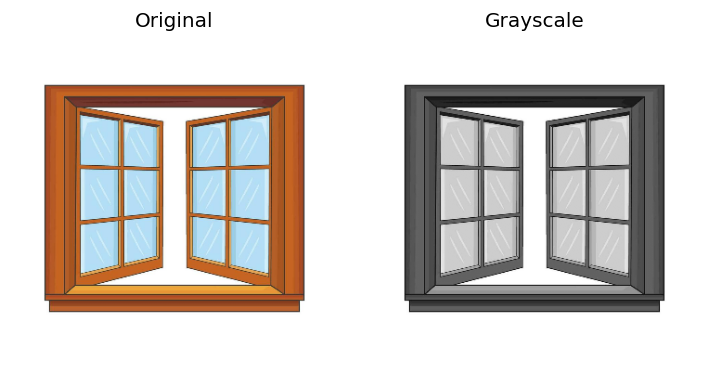

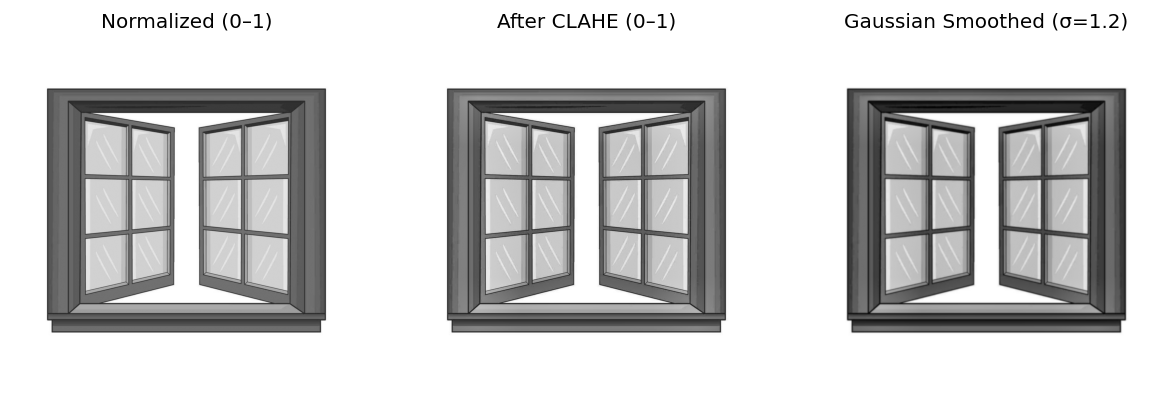

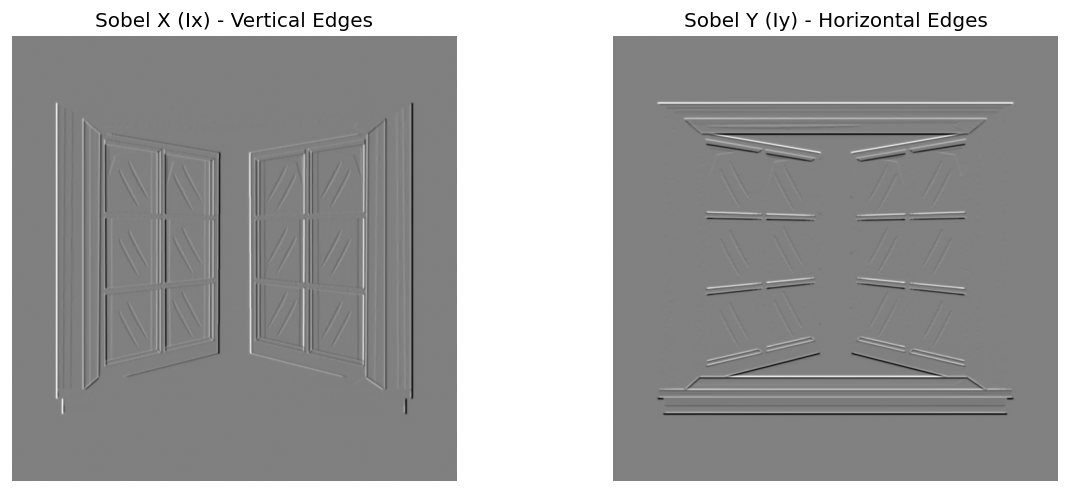

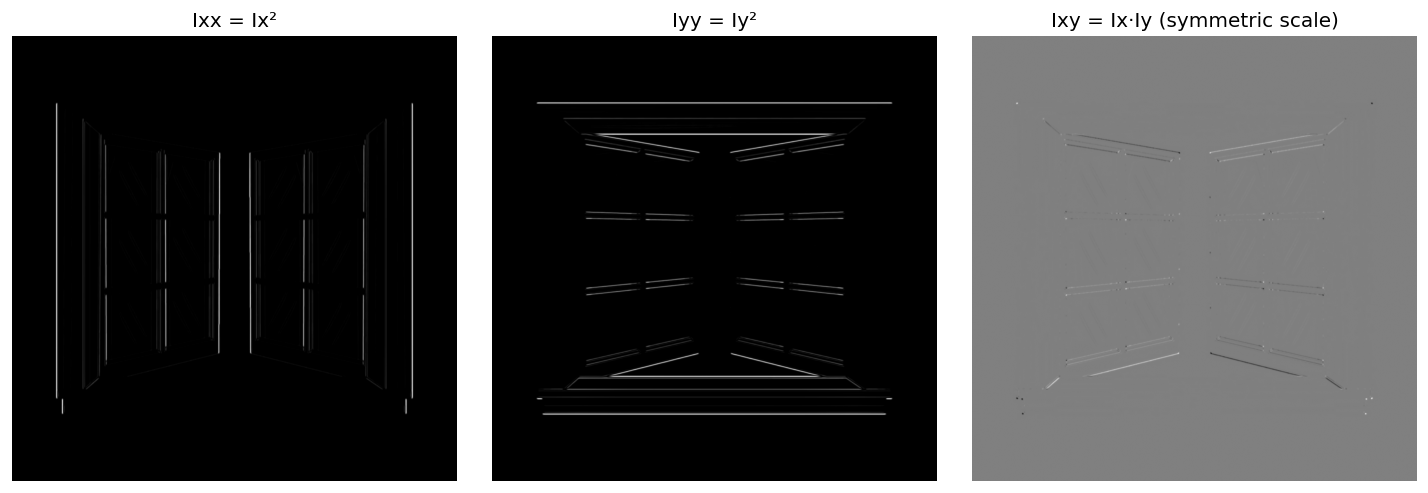

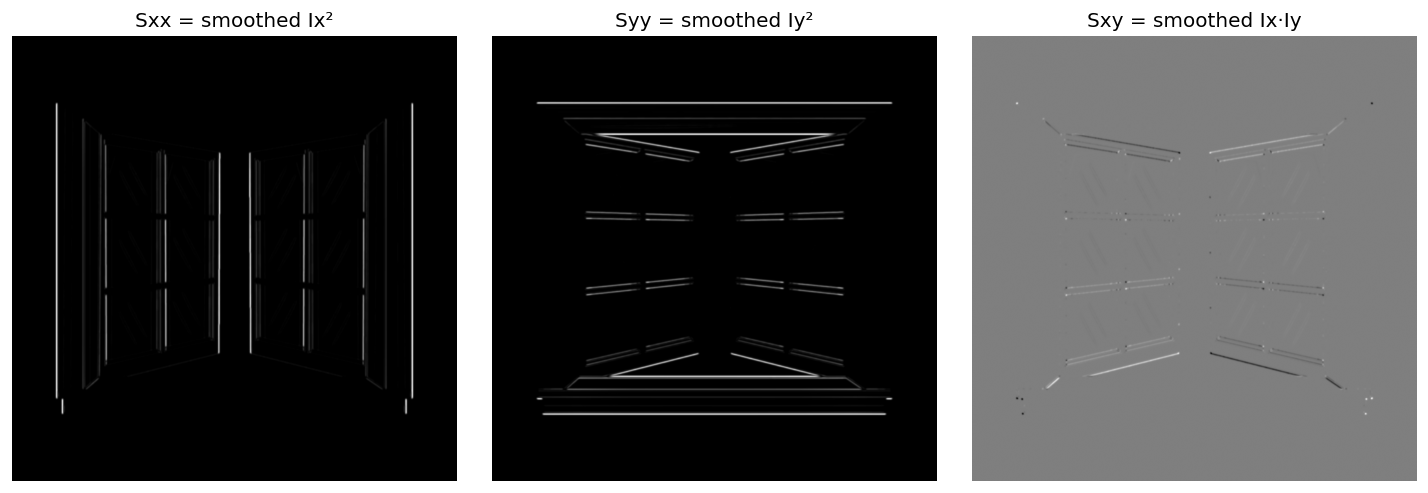

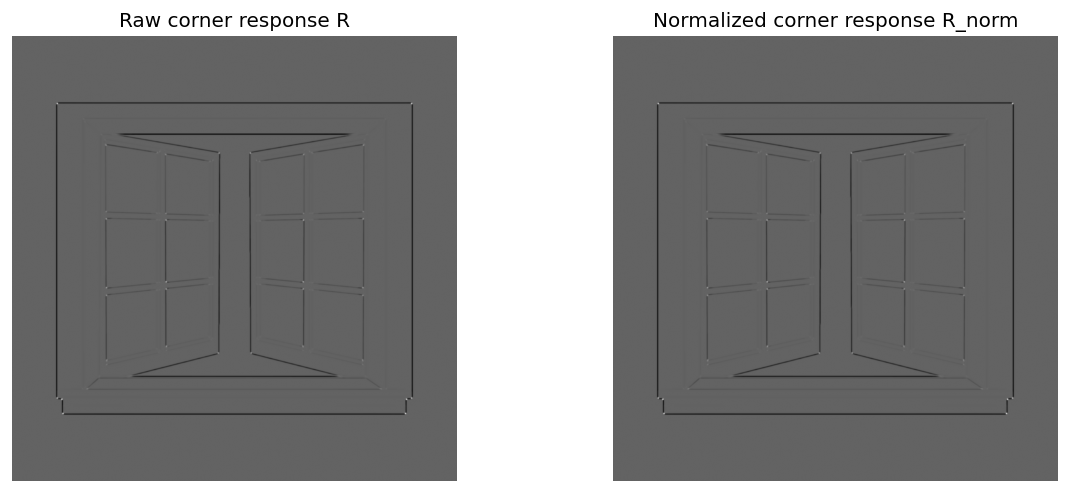

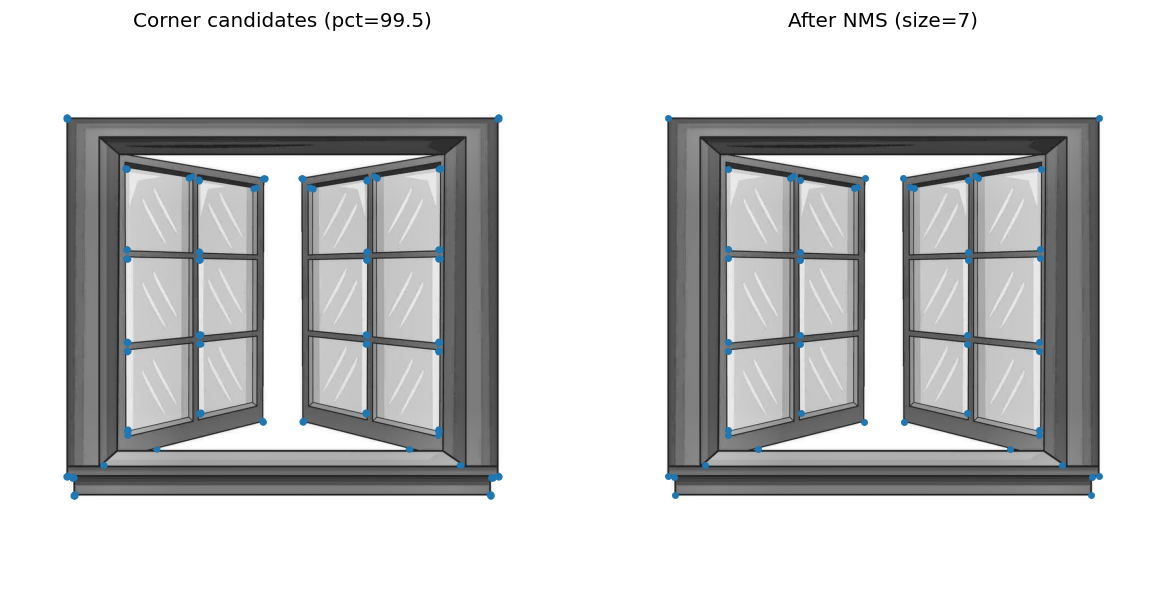

Number of final corners after NMS: 50
Corners BEFORE minDistance: 50
Corners AFTER minDistance: 46


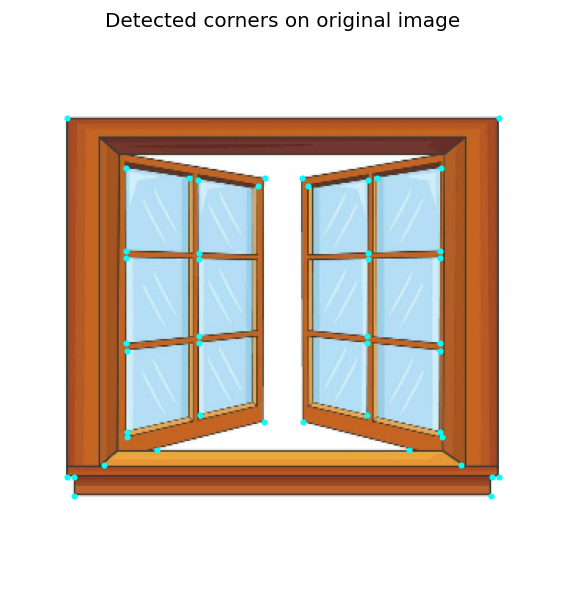

[(110.88263702392578, 831.6502685546875),
 (867.1692504882812, 831.6600952148438),
 (98.27670288085938, 147.27688598632812),
 (880.7164916992188, 147.20948791503906),
 (867.4869384765625, 797.59423828125),
 (110.45500183105469, 797.6005249023438),
 (880.5857543945312, 797.77099609375),
 (98.36476135253906, 797.7089233398438),
 (337.6269836425781, 542.4930419921875),
 (642.3446655273438, 542.4886474609375),
 (337.34661865234375, 403.3272399902344),
 (643.1029052734375, 403.4046630859375),
 (523.7453002929688, 256.6361389160156),
 (456.54364013671875, 256.64892578125),
 (774.4620361328125, 400.5438232421875),
 (337.6999816894531, 555.4725341796875),
 (205.87127685546875, 555.5911254882812),
 (454.59869384765625, 697.9664306640625),
 (205.52590942382812, 400.50225830078125),
 (642.3731689453125, 555.4346313476562),
 (774.5283203125, 555.5201416015625),
 (525.4651489257812, 697.9451293945312),
 (338.40350341796875, 685.16259765625),
 (206.06961059570312, 568.9877319335938),
 (204.575012207

In [407]:
folder = "/content/drive/MyDrive/CornerDetection"
exts = (".jpg", ".jpeg", ".png", ".bmp")

all_images = [
    os.path.join(folder, f)
    for f in os.listdir(folder)
    if f.lower().endswith(exts)
]

print("Found", len(all_images), "images:")
for p in all_images:
    print(p)

path = random.choice(all_images)
print("Random image chosen:", path)

process_image(path)
